In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import integrate as inte
from astropy import units as u
from astropy import constants as const
import pandas as pd
import xarray as xr

In [2]:
#constants and units
H0 = 67.9 * u.km/u.s/u.Mpc
c = const.c
G = const.G.to(u.km**2 * u.Mpc /u.Msun/u.s**2)

Rate = 30.0 /(u.Gpc**3 * u.year)

## Calculate $\Omega_{GW}$ 
$ \rho_c c^2 \Omega_{GW} (f) = \frac{(f \pi G)^{2/3}}{3} \mathcal{R_0} \mathcal{M}^{5/3} \int_0^{z_f} \frac{\mathrm{d}z}{(1+z)^{1/3} H(z)} \text{(z-evo)} $

where $ \text{z-evo} = \mathcal{C}(\alpha,\beta,z_p) \frac{(1+z)^{\alpha}}{1 + (\frac{1+z}{1+z_p})^{\alpha+\beta}} $ is the redshift evolution of the merger rate.

In [3]:
#redshift evolution
def int_over_z(z,Omega_m,Omega_Lam,Omega_r, zp=0,alpha=0,beta=0):
    ''' putting in values for zp, alpha, and beta gives the redshift evolution in Callister et al 2020'''
    Omega_k = 1 - (Omega_m + Omega_Lam + Omega_r)
    H_z = np.sqrt(Omega_Lam + Omega_r * (1 + z)**4. + Omega_m * (1 + z)**3. + Omega_k * (1 + z)**2. )
    
    z_evo = np.power(1+z,alpha)/(1+ np.power((1+z)/(1+zp),beta+alpha)) # checkthis?
    C =  1 + np.power(1+zp,-1*(alpha+beta))
    
    integrand = z_evo * C / ((1+z)*H_z)
    return integrand

In [4]:
#--- get all z-evos for different peak reshift and rising power law ---#
zp_array = np.linspace(0,5)
alpha_arr = np.linspace(-20,20)
z_int_arr = np.zeros((len(zp_array),len(alpha_arr))) / H0.unit

for z in range(len(zp_array)):
    for a in range(len(alpha_arr)):
        z_params = [zp_array[z], alpha_arr[a], 3.] #beta=3 always
        z_int = inte.quad(int_over_z,0,1e3,
                         args=(0.3, 0.7,0,z_params[0],
                               z_params[1],z_params[2])
                        )[0]
        z_int *= 1./H0
        z_int_arr[z,a] = z_int

## Convert from $\Omega_{GW}$ to Optimal SNR

$ <S/N>_{opt}^2 = 2 T (\frac{3H_O^2}{10\pi^2})^2 \int_0^\infty df \frac{\gamma^2(f) \Omega_{GW}^2(f)}{f^6 P_1(f) P_2(f)}  $ 

where $\gamma(f)$ is the overlap reduction function, $\Omega_{GW} \propto f^{2/3}$ and $P_i (f)$ are the PSDs of each of the two LIGO detectors.

Plugging in $\Omega_{GW}$ from above yields

$<S/N>_{opt} = (\pi G)^{2/3} \frac{\mathcal{R}_0 \mathcal{M}^{5/3}}{\rho_c c^2} \text{(z-evo)} \frac{H_0^2}{10 \pi^2} \sqrt{2 T \int_0^\infty df \frac {f^{-14/3} \gamma^2(f)}{P_1(f) P_2(f)} }$

In [5]:
def overlap_reduction(f):
    if f < 250:
        olr = olr_below
    else:
        olr = olr_above
    return np.interp(f,olr[:,0],olr[:,1])

def f_integrand(f,obs_run):
    overlap = overlap_reduction(f) **2. 
    freq_power = np.power(f,-14./3.)
    if obs_run == 'O1':
        PH = PSD_O1_xr.sel(freq=f,method='nearest').Hanford
        PL = PSD_O1_xr.sel(freq=f,method='nearest').Livingston
    elif obs_run== 'O2':
        PH = PSD_O2_xr.sel(freq=f,method='nearest').Hanford
        PL = PSD_O2_xr.sel(freq=f,method='nearest').Livingston
        
    return overlap * freq_power / (PH * PL)

I get PSDs $P_1$ and $P_2$ from the Livingston and Hanford's "representative best" strain curves from O1 and O2. Links here: 

H1+L1 sensitivity spectra, representative best of O2: https://dcc.ligo.org/LIGO-P1800374/public

H1 sensitivity spectra, representative of O1: https://dcc.ligo.org/LIGO-G1600150/public

L1 sensitivity spectra, representative of O1: https://dcc.ligo.org/LIGO-G1600151/public

The PSD is the square of the strain curve (as far as I know, at least).

I get the overlap reduction function $\gamma$ by digitizing the curves in Figure 2 of Allen+Romano 1999. Link here: https://journals.aps.org/prd/abstract/10.1103/PhysRevD.59.102001

In [6]:
#--- load in external datasets ---#
olr_below = np.genfromtxt("data/overlap_reduction_below_200hz.csv",delimiter=',')
olr_below=olr_below[:-2]
olr_above=np.genfromtxt("data/overlap_reduction_above_200hz.csv",delimiter=',')

PSD_O1 = pd.DataFrame()
PSD_O1['freq'] = np.genfromtxt("data/2015_10_24_15_09_43_H1_O1_strain.txt")[:,0]
    #strains are the sqrt of the PSD
PSD_O1['Hanford'] = np.power(np.genfromtxt("data/2015_10_24_15_09_43_H1_O1_strain.txt")[:,1],2.) 
PSD_O1['Livingston'] = np.power(np.genfromtxt("data/2015_10_24_15_10_43_L1_O1_strain.txt")[:,1],2.)

PSD_O1_xr = xr.Dataset.from_dataframe(PSD_O1.set_index('freq'))

PSD_O2 = pd.DataFrame()
PSD_O2['freq'] = np.genfromtxt("data/2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt")[:,0]
PSD_O2['Hanford'] =  np.power(np.genfromtxt("data/2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt")[:,1],2.)
PSD_O2['Livingston'] =  np.power(np.genfromtxt("data/2017-08-06_DCH_C02_L1_O2_Sensitivity_strain_asd.txt")[:,1],2.)

PSD_O2_xr = xr.Dataset.from_dataframe(PSD_O2.set_index('freq'))

In [12]:
#--- set constants ---#
#O1: September 12, 2015 to January 19, 2016
days_in_O1 = len(pd.date_range(start='09-12-2015',end='01-19-2016',freq='D')) * u.day

#O2: November 30, 2016 to August 25, 2017
days_in_O2 = len(pd.date_range(start='11-30-2016',end='08-25-2017',freq='D')) * u.day

prefac_inner_prod = ( 3 * H0**2. / (10 * np.pi**2.))
f_integral_O1 = inte.quad(f_integrand, 1.5,6e3,args='O1', limit=200
                         )[0] * (u.s)**3 * (u.Hz)**(4./3)
f_integral_O2 = inte.quad(f_integrand, 1.5,6e3,args='O2', limit=200
                         )[0] * (u.s)**3 * (u.Hz)**(4./3)

Mchirp = 30.* u.Msun
rhoc2 = ( c**2. ) * ( H0**2. ) * 3. /( 8. * np.pi * G )

prefac_omegaGW = np.power(np.pi*G,2./3.) * Rate * np.power(Mchirp,5./3.) * z_int_arr / rhoc2

Total SNR is additive from O1 and O2 (I think, not sure)
$S/N_{total} = S/N_{O1} + S/N_{O2} \propto \sqrt{T_{O1}} + \sqrt{T_{O2}} $

In [15]:
rho_opt_O1 = prefac_inner_prod * prefac_omegaGW * np.sqrt(2 * days_in_O1 * f_integral_O1)
rho_opt_O2 = prefac_inner_prod * prefac_omegaGW * np.sqrt(2 * days_in_O2 * f_integral_O2)
SNR_arr = (rho_opt_O1+rho_opt_O2).to(u.m/u.m)

#### Plot in the same style and with the same limits so as to make an easy comparison

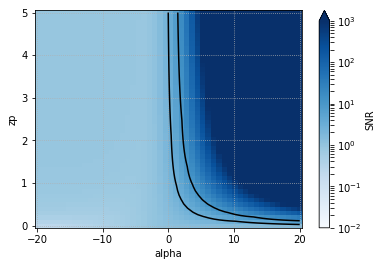

<xarray.DataArray 'SNR' ()>
array(700.684331)
Coordinates:
    zp       float64 1.02
    alpha    float64 10.2


In [22]:
SNR_xr = xr.DataArray(SNR_arr,
                        dims = ('zp','alpha'),
                        coords = (zp_array,alpha_arr),
                        name = 'SNR')
SNR_xr.plot(norm=LogNorm(vmin=1e-2,vmax=1e3),cmap='Blues')
SNR_xr.plot.contour(levels=[3,10],colors='black')
plt.grid(linestyle=':')
plt.show()

print(SNR_xr.sel({'alpha':10,'zp':1},method='nearest'))

I find that at $z_{peak}= 1, \alpha=10$, I get an SNR of ~700, whereas figure 2 of S+M seems to get SNR=3

## Appendix: Alternate integration

I get a warning message when I use scipy.integrate.quad(), I think because the PSDs have too many values for the integrator to work with order 100 samples. TI checked and the integration error is only one order of magnitude lower than the actual value. So I try it a different way that uses all of the values in the PSDs.

In [18]:
f_integrand_arr = (np.power(PSD_O2_xr.freq, -14./3.) \
                   * np.interp(PSD_O2_xr.freq,olr_above[:,0],olr_above[:,1]) **2. \
                  )/ (PSD_O2_xr.Hanford * PSD_O2_xr.Livingston)
f_integral_O2_tz = inte.trapz(f_integrand_arr) * (u.s)**3 * (u.Hz)**(4./3)

f_integrand_arr = (np.power(PSD_O1_xr.freq, -14./3.) \
                   * np.interp(PSD_O1_xr.freq,olr_above[:,0],olr_above[:,1]) **2. \
                  ) / (PSD_O1_xr.Hanford * PSD_O1_xr.Livingston)
f_integral_O1_tz = inte.trapz(f_integrand_arr) * (u.s)**3 * (u.Hz)**(4./3)

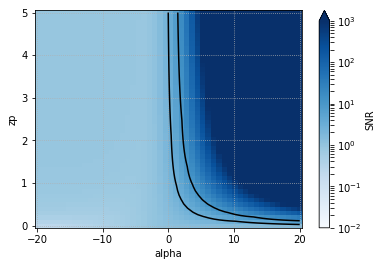

In [19]:
rho_opt_O1 = prefac_inner_prod * prefac_omegaGW * np.sqrt(
    2 * days_in_O1 * f_integral_O1_tz)
rho_opt_O2 = prefac_inner_prod * prefac_omegaGW * np.sqrt(
    2 * days_in_O2 * f_integral_O2_tz)
SNR_arr = (rho_opt_O1+rho_opt_O2).to(u.m/u.m)

SNR_xr = xr.DataArray(SNR_arr,
                        dims = ('zp','alpha'),
                        coords = (zp_array,alpha_arr),
                        name = 'SNR')
SNR_xr.plot(norm=LogNorm(vmin=1e-2,vmax=1e3),cmap='Blues')
SNR_xr.plot.contour(levels=[3,10],colors='black')
plt.grid(linestyle=':')
plt.show()

This doesn't help and actually makes the disagreement slightly worse! :(